# Copyright Netherlands eScience Center <br>
** Function     : Analyze the trend of net surface flux from coordinated experiments** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.08.09 ** <br>
** Last Update  : 2019.08.29 ** <br>
Description     : This notebook aims to analyze the trend of net surface flux from multiple coordinated experiments in Blue Action WP3. It contributes to the Deliverable 3.1. <br>
Return Values   : netCDF4 <br>
Caveat          : The fields used here are post-processed monthly mean fields. It includes AMET from:
* EC Earth (DMI)
* CMCC-CM (CMCC)
* WACCM6 (WHOI)
* NorESM (NERSC)
* HadGEM  (UoS)
* EC Earth (NLeSC)

In [1]:
%matplotlib inline
import numpy as np
import sys
#sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
sys.path.append("../")
import analyzer
import visualizer
import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# read netcdf with scipy (no bothering from attributes)
import scipy as sp
from scipy.io import netcdf

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

|Model and Organization | Exp 1 | Exp 2 | Exp 3 | Exp 4 |    time   |
|-----------------------|-------|-------|-------|-------|-----------|
|    EC Earth (NLeSC)   |   20  |   20  |   1   |   1   | 1979-2015 (exp1&2) 1979-2013 (exp3&4) |
|     EC Earth (DMI)    |   20  |   20  |   20  |   20  | 1979-2015 (exp1&2) 1979-2013 (exp3&4) |
|     CMCC-CM (CMCC)    |   10  |   10  |   0   |   0   | 1979-2014 |
|      WACCM6 (WHOI)    |   30  |   30  |   30  |   30  | 1979-2014 (exp1&2) 1979-2012 (exp3&4) |
|     NorESM (NERSC)    |   20  |   20  |   20  |   20  | 1979-2014 (exp1&2) 1979-2013 (exp3&4) |
|     HadGEM  (UoS)     |   10  |   10  |   5   |   5   | 1979-2014 (exp1&2) 1979-2013 (exp3&4) |
|   IAP-AGCM (IAP-NZC)  |   15  |   15  |   15  |   15  | 1979-2015 (exp1&2) 1979-2013 (exp3&4) |
|     IPSL-CM (CNRS)    |   30  |   30  |   20  |   20  | 1979-2014 |
|      MPIESM (MPI)     |   10  |   10  |   10  |   10  | 1979-2014 (exp1&2) 1979-2013 (exp3&4) |

In [3]:
################################   Input zone  ######################################
# specify starting and ending time
start_year = 1979
end_year = 2014
# specify data path
datapath = '/home/ESLT0068/WorkFlow/Core_Database_BlueAction_WP3/IPSL-CM_CNRS'
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/BlueAction/WP3/JointAnalysis_AMET/AMIP/spatial'
# ensemble number
ensemble_12 = 30
ensemble_34 = 20
# experiment number
exp = 4
# example file
datapath_example = os.path.join(datapath, 'hfls', 'hfls_Amon_IPSL-CM6A-LR_BlAct-EXP1_r10i1p1f1_gr_197901-201412.nc')
####################################################################################

In [4]:
def var_key_retrieve(datapath, exp_num, ensemble_num):
    # get the path to each datasets
    print ("Start retrieving datasets of experiment {} ensemble number {}".format(exp_num+1, ensemble_num))
    # get data path   
    datapath_hfls = os.path.join(datapath, 'hfls', 'hfls_Amon_IPSL-CM6A-LR_BlAct-EXP{}_r{}i1p1f1_gr_197901-201412.nc'.format(exp_num+1, ensemble_num+1))
    datapath_hfss = os.path.join(datapath, 'hfss', 'hfss_Amon_IPSL-CM6A-LR_BlAct-EXP{}_r{}i1p1f1_gr_197901-201412.nc'.format(exp_num+1, ensemble_num+1))
    
    datapath_rlds = os.path.join(datapath, 'rlds', 'rlds_Amon_IPSL-CM6A-LR_BlAct-EXP{}_r{}i1p1f1_gr_197901-201412.nc'.format(exp_num+1, ensemble_num+1))
    datapath_rlus = os.path.join(datapath, 'rlus', 'rlus_Amon_IPSL-CM6A-LR_BlAct-EXP{}_r{}i1p1f1_gr_197901-201412.nc'.format(exp_num+1, ensemble_num+1))
    datapath_rsds = os.path.join(datapath, 'rsds', 'rsds_Amon_IPSL-CM6A-LR_BlAct-EXP{}_r{}i1p1f1_gr_197901-201412.nc'.format(exp_num+1, ensemble_num+1))
    datapath_rsus = os.path.join(datapath, 'rsus', 'rsus_Amon_IPSL-CM6A-LR_BlAct-EXP{}_r{}i1p1f1_gr_197901-201412.nc'.format(exp_num+1, ensemble_num+1))
     
    # get the variable keys    
    key_hfls = Dataset(datapath_hfls)
    key_hfss = Dataset(datapath_hfss)
    key_rlds = Dataset(datapath_rlds)
    key_rlus = Dataset(datapath_rlus)
    key_rsds = Dataset(datapath_rsds)
    key_rsus = Dataset(datapath_rsus)

    print ("Retrieving datasets successfully and return the variable key!")
    return key_hfls, key_hfss, key_rlds, key_rlus, key_rsds, key_rsus

In [5]:
def sflux(key_hfls, key_hfss, key_rlds, key_rlus,
          key_rsds, key_rsus, lat, lon):
    # get all the varialbes
    var_hfls = key_hfls.variables['hfls'][:,::-1,:] # surface latent heat flux W/m2
    var_hfss = key_hfss.variables['hfss'][:,::-1,:] # surface sensible heat flux W/m2 
    var_rlds = key_rlds.variables['rlds'][:,::-1,:] # surface downwelling longwave radiation W/m2
    var_rlus = key_rlus.variables['rlus'][:,::-1,:] # surface upward longwave radiation W/m2
    
    var_rsds = key_rsds.variables['rsds'][:,::-1,:] # surface downwelling shortwave radiation W/m2
    var_rsus = key_rsus.variables['rsus'][:,::-1,:] # surface upward shortwave radiation W/m2
    
    #size of the grid box
    #dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * lat /
    #                                        360) / len(lon) 
    #dy = np.pi * constant['R'] / len(lat)
    # calculate total turbulent flux at surface
    turb_flux_surf = - var_hfls[:,:25,:] - var_hfss[:,:25,:]
    turb_flux_surf = turb_flux_surf.reshape(-1,12,len(lat),len(lon))    
    # calculate total net energy flux at surface
    net_flux_surf = - var_hfls[:,:25,:] - var_hfss[:,:25,:] + var_rlds[:,:25,:] -\
                    var_rlus[:,:25,:] + var_rsds[:,:25,:] - var_rsus[:,:25,:]
    net_flux_surf = net_flux_surf.reshape(-1,12,len(lat),len(lon))

    return net_flux_surf, turb_flux_surf

Start retrieving datasets of experiment 1 ensemble number 0
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 1
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 2
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 3
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 4
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 5
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 6
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 7
Retrieving datasets successfully and return the variable key!
Start retrieving dataset

../analyzer.py:434: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a[i,j], b[i,j] = np.linalg.lstsq(A,series[:,i,j])[0]


Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


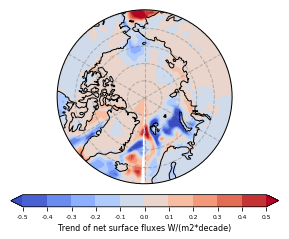

Input array should have dimensions (year,month,lat,lon)
The input data does not have the dimension of ensemble.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


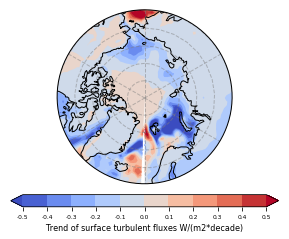

Start retrieving datasets of experiment 2 ensemble number 0
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 1
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 2
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 3
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 4
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 5
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 6
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 2 ensemble number 7
Retrieving datasets successfully and return the variable key!
Start retrieving dataset

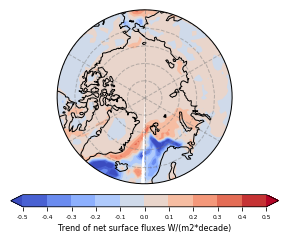

Input array should have dimensions (year,month,lat,lon)
The input data does not have the dimension of ensemble.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


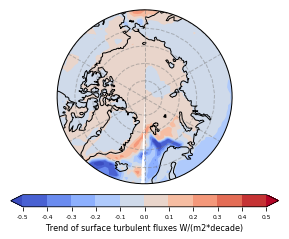

Start retrieving datasets of experiment 3 ensemble number 0
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 1
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 2
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 3
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 4
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 5
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 6
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 3 ensemble number 7
Retrieving datasets successfully and return the variable key!
Start retrieving dataset

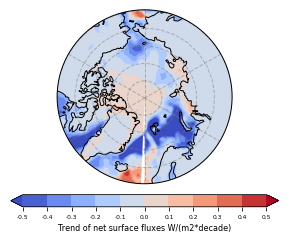

Input array should have dimensions (year,month,lat,lon)
The input data does not have the dimension of ensemble.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


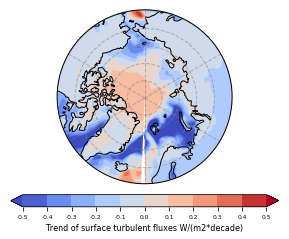

Start retrieving datasets of experiment 4 ensemble number 0
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 1
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 2
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 3
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 4
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 5
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 6
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 4 ensemble number 7
Retrieving datasets successfully and return the variable key!
Start retrieving dataset

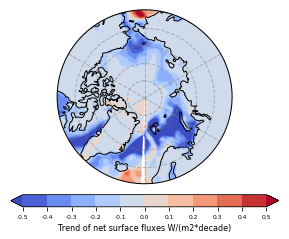

Input array should have dimensions (year,month,lat,lon)
The input data does not have the dimension of ensemble.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


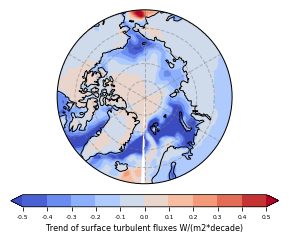

In [6]:
if __name__=="__main__":
    ####################################################################
    ######  Create time namelist matrix for variable extraction  #######
    ####################################################################
    lat_CNRS_60N = 24
    # date and time arrangement
    # namelist of month and days for file manipulation
    namelist_month = ['01','02','03','04','05','06','07','08','09','10','11','12']
    ensemble_list = ['01','02','03','04','05','06','07','08','09','10',
                     '11','12','13','14','15','16','17','18','19','20',
                     '21','22','23','24','25','26','27','28','29','30',]
    # index of months
    period_1979_2014 = np.arange(start_year,end_year+1,1)
    index_month = np.arange(1,13,1)
    ####################################################################
    ######       Extract invariant and calculate constants       #######
    ####################################################################
    # get basic dimensions from sample file
    key_example = Dataset(datapath_example)
    lat = key_example.variables['lat'][::-1] # descending lat
    #print(lat)
    lon = key_example.variables['lon'][:]
    #print(lon)
    # get invariant from benchmark file
    Dim_year_1979_2014 = len(period_1979_2014)
    Dim_month = len(index_month)
    Dim_latitude = len(lat[:25])
    Dim_longitude = len(lon)
    #############################################
    #####   Create space for stroing data   #####
    ############################################# 
    # loop for calculation
    for i in range(exp):
        if i<2:
            ensemble = ensemble_12
            pool_sflux_1979_2014 = np.zeros((ensemble,Dim_year_1979_2014,
                                             Dim_month,Dim_latitude,Dim_longitude),dtype = float)
            pool_turb_1979_2014 = np.zeros((ensemble,Dim_year_1979_2014,
                                             Dim_month,Dim_latitude,Dim_longitude),dtype = float)
        else:
            ensemble = ensemble_34
            pool_sflux_1979_2014 = np.zeros((ensemble,Dim_year_1979_2014,
                                             Dim_month,Dim_latitude,Dim_longitude),dtype = float)
            pool_turb_1979_2014 = np.zeros((ensemble,Dim_year_1979_2014,
                                             Dim_month,Dim_latitude,Dim_longitude),dtype = float)            
        for j in range(ensemble):
            # get variable keys
            key_hfls, key_hfss, key_rlds, key_rlus, key_rsds,\
            key_rsus = var_key_retrieve(datapath, i, j)
            pool_sflux_1979_2014[j,:,:,:,:],\
            pool_turb_1979_2014[j,:,:,:,:] = sflux(key_hfls, key_hfss, key_rlds, key_rlus,
                                                   key_rsds, key_rsus, lat[:25], lon)            
        ####################################################################
        ######                    Calculating Trend                  #######
        ####################################################################
        # calculate trend and take ensemble mean
        ens_avg_CNRS_exp = analyzer.spatial(np.mean(pool_sflux_1979_2014[:],0))
        ens_avg_CNRS_exp.anomaly()
        ens_avg_CNRS_exp.trend()
        #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
        ticks = np.linspace(-0.5,0.5,11)
        label = 'Trend of net surface fluxes W/(m2*decade)'
        visualizer.plots.geograph(lat[:25], lon, ens_avg_CNRS_exp._a*10,
                                      label, ticks, os.path.join(output_path,'SFlux_trend',
                                      'trend_spatial_IPSL-CM_CNRS_SFlux_exp_{}.png'.format(i)),
                                      boundary = 'polar')
        # calculate trend and take ensemble mean
        ens_avg_CNRS_exp = analyzer.spatial(np.mean(pool_turb_1979_2014[:],0))
        ens_avg_CNRS_exp.anomaly()
        ens_avg_CNRS_exp.trend()
        #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
        ticks = np.linspace(-0.5,0.5,11)
        label = 'Trend of surface turbulent fluxes W/(m2*decade)'
        visualizer.plots.geograph(lat[:25], lon, ens_avg_CNRS_exp._a*10,
                                      label, ticks, os.path.join(output_path,'Turbulent_trend',
                                      'trend_spatial_IPSL-CM_CNRS_turb_exp_{}.png'.format(i)),
                                      boundary = 'polar')      